In [1]:
def get_sequence_from_fasta_multiline(fa_dir, backbone_id, id_num):
    fasta_path = f'{fa_dir}/{backbone_id}.fa'
    header_keyword = f">{backbone_id}, id={id_num},"
    with open(fasta_path) as f:
        lines = f.readlines()

    get_seq = False
    seq = ""
    for line in lines:
        if line.startswith(">"):
            get_seq = line.startswith(header_keyword)
            continue
        if get_seq:
            if line.strip():
                seq += line.strip()
            else:
                break
    return seq if seq else None


def get_lmpnn_data(tag, dir):
    base = dir
    model_path = f'{base}/packed/{tag}.pdb'
    relaxed_model_path = f'{base}/packed/{tag}_betarelax.pdb'
    
    fasta_dir = f'{base}/seqs'
    backbone_id = '_packed'.join(tag.split('_packed')[:-1])
    id_num = tag.split('_')[-2]
    seq = get_sequence_from_fasta_multiline(fasta_dir, backbone_id, id_num)

    lmpnn_item = {
        'path': model_path,
        'relaxed_path': relaxed_model_path,
        'seq': seq
    }
    return lmpnn_item

import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import numpy as np
import re

In [2]:
paths = glob('./betagen_*pht.csv')
col_1 = 'lmpnn'
dfs = [pd.read_csv(path, low_memory=False) for path in paths]
df = pd.concat(dfs, ignore_index=True)
df = df.drop(columns=[col for col in df.select_dtypes(include=[np.number]).columns if (df[col] == 0).all()])
lmpnn_dir = '../3_lmpnn/output'
df['lmpnn_data'] = df['tag'].apply(lambda x: get_lmpnn_data(x, lmpnn_dir))
df_exp = pd.json_normalize(df['lmpnn_data'])
df = pd.concat([df_exp, df.drop(columns=['lmpnn_data'])], axis=1)
df.columns = pd.MultiIndex.from_product([[col_1], df.columns])

def extract_id(tag):
    m = re.match(r'^(result_\d+)', tag)
    return m.group(1) if m else tag

df_lmpnn = df.copy()
df_diff = pd.read_parquet('./lmpnn_list.parquet')
df_merged = pd.merge(
    df_diff,
    df_lmpnn,
    on=df_diff.columns.intersection(df_lmpnn.columns).tolist(),
    how='right'
)
df_merged.to_parquet('lmpnn_pht.parquet')
df_merged

lmpnn                                                     \
                      tag                                               path   
0     result_9_packed_3_1   ../3_lmpnn/output/packed/result_9_packed_3_1.pdb   
1     result_2_packed_3_1   ../3_lmpnn/output/packed/result_2_packed_3_1.pdb   
2     result_2_packed_1_1   ../3_lmpnn/output/packed/result_2_packed_1_1.pdb   
3     result_9_packed_1_1   ../3_lmpnn/output/packed/result_9_packed_1_1.pdb   
4     result_9_packed_4_1   ../3_lmpnn/output/packed/result_9_packed_4_1.pdb   
..                    ...                                                ...   
283  result_52_packed_8_1  ../3_lmpnn/output/packed/result_52_packed_8_1.pdb   
284  result_14_packed_6_1  ../3_lmpnn/output/packed/result_14_packed_6_1.pdb   
285  result_61_packed_5_1  ../3_lmpnn/output/packed/result_61_packed_5_1.pdb   
286  result_14_packed_4_1  ../3_lmpnn/output/packed/result_14_packed_4_1.pdb   
287  result_61_packed_7_1  ../3_lmpnn/output/packed/result_61_packed_7_1.pdb   

                diffusion            \
                       id     batch   
0     result_9_packed_3_1  pht_demo   
1     result_2_packed_3_1  pht_demo   
2     result_2_packed_1_1  pht_demo   
3     result_9_packed_1_1  pht_demo   
4     result_9_packed_4_1  pht_demo   
..                    ...       ...   
283  result_52_packed_8_1  pht_demo   
284  result_14_packed_6_1  pht_demo   
285  result_61_packed_5_1  pht_demo   
286  result_14_packed_4_1  pht_demo   
287  result_61_packed_7_1  pht_demo   

                                                 lmpnn  \
                                          relaxed_path   
0    ../3_lmpnn/output/packed/result_9_packed_3_1_b...   
1    ../3_lmpnn/output/packed/result_2_packed_3_1_b...   
2    ../3_lmpnn/output/packed/result_2_packed_1_1_b...   
3    ../3_lmpnn/output/packed/result_9_packed_1_1_b...   
4    ../3_lmpnn/output/packed/result_9_packed_4_1_b...   
..                                                 ...   
283  ../3_lmpnn/output/packed/result_52_packed_8_1_...   
284  ../3_lmpnn/output/packed/result_14_packed_6_1_...   
285  ../3_lmpnn/output/packed/result_61_packed_5_1_...   
286  ../3_lmpnn/output/packed/result_14_packed_4_1_...   
287  ../3_lmpnn/output/packed/result_61_packed_7_1_...   

                                                                               \
                                                   seq        ddg      fa_rep   
0    AAASAVADLDLLLAVLAGLAGATLADGSPVLAHGSLEEVRAAAKSL... -21.769676   77.833733   
1    ANDGSVLANAVAALAALSPTLEEALALCRELEVLWPEAGRVARLAT... -11.826141   83.517403   
2    PNDGRVLALAVAALQALSATLEEALALCERLRALWPELGEVAELAV... -17.531549   86.033737   
3    SAPAAVASRALLLGVLAGLTGATLADGSPVIAHGSLEEVRAAVAAA... -23.326235   74.168266   
4    ARPSTVADRSLVLAVLAGLEGARLADGSPVPAHASLEEVAAAAETL... -18.854092   72.070038   
..                                                 ...        ...         ...   
283  ASAAEQAAAALAATVLQAAQDAARMAGVENFIKLAKEEDEKDPSRR... -10.717464   57.487091   
284  SRLEEQMRELAAFMGLSEEATELLTAMRQARRDGDEERAAALEAEL... -11.908579   87.888306   
285  SEEVVEKIIETLEKVAGELLKDRVDLEVLARALVETQTLSPEEAAR... -15.823974  113.864616   
286  SWLEEAARRMAEFFGLTPEAAALLEARLRARAEGDEEKAAELEARL... -20.287291   85.552299   
287  SQELLDAMKETLKRLLGDWVEKNIDLDVLAEAMAATLTLSEEAAAR... -22.709888  121.304863   

                                                  
    res_totalscore  totalscore O1_hbond O2_hbond  
0        -0.719053  -75.500519        0        0  
1        -1.334414 -144.116653        0        0  
2        -1.184946 -127.974129        0        0  
3        -0.764134  -80.234077        0        0  
4        -0.988156 -103.756416        0        0  
..             ...         ...      ...      ...  
283      -1.386764 -158.091125        0        1  
284      -1.059797 -130.355042        0        0  
285      -1.319577 -166.266647        0        1  
286      -1.353849 -166.523407        0        0  
287      -1.367058 -172.249359        0        1  

In [3]:
def plot_hb_combo(df, combo_cols, count_col=None, title=None, log_scale=True, ax=None):
    if count_col is None:
        data3 = df.groupby(combo_cols).size().reset_index(name='count')
        count_col = 'count'
    else:
        data3 = df
    combos = list(data3[combo_cols].itertuples(index=False, name=None))
    combos_sorted = sorted(combos, key=lambda x: (sum(x),) + tuple(-i for i in x[:-1]) + (-x[-1],))
    combo_counts_dict = dict(zip(combos, data3[count_col]))

    x_labels = []
    y_counts = []
    for combo in combos_sorted:
        label = ",".join(map(str, combo))
        count = combo_counts_dict.get(combo, 0)
        if count > 0:
            x_labels.append(label)
            y_counts.append(count)

    # 축 선택
    bar_func = ax.bar if ax is not None else plt.bar
    bar_func(x_labels, y_counts)
    if log_scale:
        if ax is not None:
            ax.set_yscale('log')
        else:
            plt.yscale('log')
    xlabel = f"({', '.join([str(col[1]) for col in combo_cols])}) Combination"

    ylabel = 'Count'
    if ax is not None:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title if title else "Combination Count")
        ax.grid()
        total_count = sum(y_counts)
        ax.text(
            0.98, 0.95,
            ha='right',
            va='top',
            transform=ax.transAxes,
            s=f"Total: {total_count:,}"
        )
    else:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title if title else "Combination Count")
        plt.grid()
        total_count = sum(y_counts)
        plt.text(
            0.98, 0.95,
            ha='right',
            va='top',
            transform=plt.gca().transAxes,
            s=f"Total: {total_count:,}"
        )
    if ax is None:
        plt.tight_layout()
        plt.show()

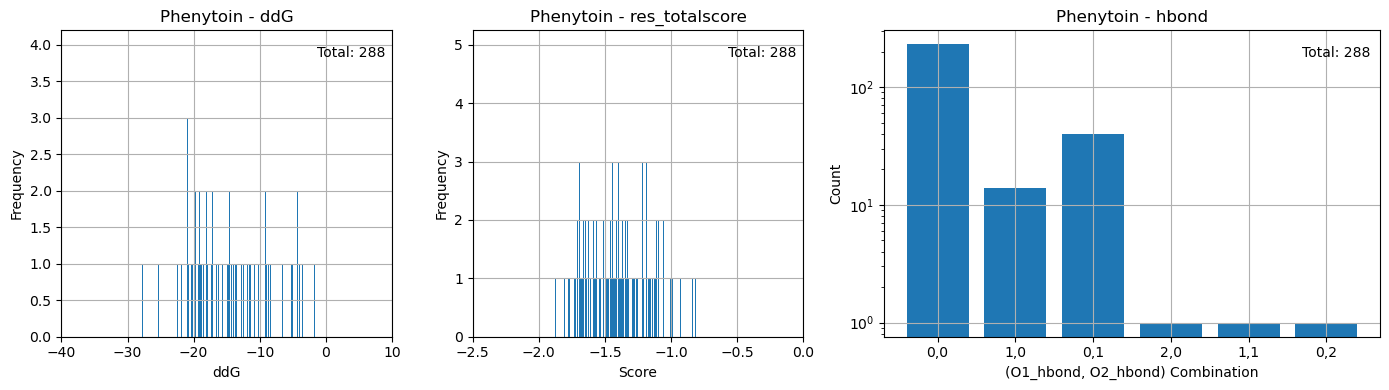

In [4]:
df = df_merged.copy()
plot_hb = True
target = 'Phenytoin'
col_1 = 'lmpnn'
if plot_hb:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'width_ratios': [1, 1, 1.5]})
else:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

data1 = df[(col_1, 'ddg')].values
axes[0].hist(data1, bins=1000, density=False)
axes[0].set_xlabel('ddG')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'{target} - ddG')
axes[0].grid()
axes[0].set_xlim(-40, 10)
total_count = len(data1)
axes[0].text(
    0.98, 0.95,
    f"Total: {total_count:,}",
    ha='right',
    va='top',
    transform=axes[0].transAxes
)

data2 = df[(col_1, 'res_totalscore')].values
axes[1].hist(data2, bins=1000, density=False)
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'{target} - res_totalscore')
axes[1].grid()
axes[1].set_xlim(-2.5, 0.0)
total_count = len(data2)
axes[1].text(
    0.98, 0.95,
    ha='right',
    va='top',
    transform=axes[1].transAxes,
    s=f"Total: {total_count:,}"
)

if plot_hb:
    hbond_cols = [col for col in df.columns if '_hbond' in str(col[1])]
    plot_hb_combo(df, hbond_cols, title=f'{target} - hbond', ax=axes[2])

plt.tight_layout()
plt.show()


In [5]:
# df_filt = df[(df[(col_1, 'O1_hbond')] > 0) & (df[(col_1, 'O2_hbond')] > 0)].drop(hbond_cols, axis=1)
df_filt = df.copy()

In [6]:
df_filt_fin = df_filt[(df_filt[(col_1, 'ddg')] < -18) & (df_filt[(col_1, 'res_totalscore')] < -1.4)]
df_filt_fin = df_filt_fin.sort_values(by=(col_1, 'ddg'), ascending=True).reset_index(drop=True)
df_filt_fin = df_filt_fin[
    [
        ('diffusion', 'id'),
        ('diffusion', 'batch'),
        # ('diffusion', 'path'),
        # ('diffusion', 'dssp'),
        # ('diffusion', 'sasa'),
        ('lmpnn', 'tag'),
        ('lmpnn', 'ddg'),
        ('lmpnn', 'fa_rep'),
        ('lmpnn', 'res_totalscore'),
        ('lmpnn', 'totalscore'),
        ('lmpnn', 'seq'),
        ('lmpnn', 'path'),
        ('lmpnn', 'relaxed_path'),
        ]
    ]
df_filt_fin.to_parquet('lmpnn_filt_pht.parquet')
df_filt_fin

diffusion                           lmpnn             \
                      id     batch                   tag        ddg   
0    result_7_packed_3_1  pht_demo   result_7_packed_3_1 -27.749462   
1   result_61_packed_8_1  pht_demo  result_61_packed_8_1 -26.640675   
2    result_7_packed_8_1  pht_demo   result_7_packed_8_1 -25.789537   
3    result_7_packed_2_1  pht_demo   result_7_packed_2_1 -25.547806   
4   result_16_packed_4_1  pht_demo  result_16_packed_4_1 -25.318375   
5   result_16_packed_7_1  pht_demo  result_16_packed_7_1 -24.987370   
6    result_7_packed_4_1  pht_demo   result_7_packed_4_1 -23.823254   
7   result_29_packed_7_1  pht_demo  result_29_packed_7_1 -22.682110   
8   result_59_packed_1_1  pht_demo  result_59_packed_1_1 -22.405994   
9   result_59_packed_6_1  pht_demo  result_59_packed_6_1 -21.156240   
10   result_7_packed_1_1  pht_demo   result_7_packed_1_1 -21.103624   
11  result_24_packed_8_1  pht_demo  result_24_packed_8_1 -20.956982   
12  result_24_packed_7_1  pht_demo  result_24_packed_7_1 -20.956400   
13  result_59_packed_3_1  pht_demo  result_59_packed_3_1 -20.733452   
14  result_55_packed_1_1  pht_demo  result_55_packed_1_1 -20.355864   
15  result_59_packed_8_1  pht_demo  result_59_packed_8_1 -20.324280   
16  result_24_packed_3_1  pht_demo  result_24_packed_3_1 -20.292067   
17  result_24_packed_6_1  pht_demo  result_24_packed_6_1 -20.236935   
18  result_59_packed_7_1  pht_demo  result_59_packed_7_1 -20.159588   
19  result_55_packed_2_1  pht_demo  result_55_packed_2_1 -19.940771   
20  result_24_packed_4_1  pht_demo  result_24_packed_4_1 -19.784569   
21  result_24_packed_5_1  pht_demo  result_24_packed_5_1 -19.718063   
22  result_10_packed_4_1  pht_demo  result_10_packed_4_1 -19.292791   
23  result_29_packed_3_1  pht_demo  result_29_packed_3_1 -19.285507   
24  result_55_packed_4_1  pht_demo  result_55_packed_4_1 -19.126881   
25  result_24_packed_1_1  pht_demo  result_24_packed_1_1 -18.947884   
26  result_55_packed_5_1  pht_demo  result_55_packed_5_1 -18.944952   
27  result_24_packed_2_1  pht_demo  result_24_packed_2_1 -18.919436   
28  result_59_packed_2_1  pht_demo  result_59_packed_2_1 -18.819977   
29  result_59_packed_5_1  pht_demo  result_59_packed_5_1 -18.560551   
30  result_16_packed_2_1  pht_demo  result_16_packed_2_1 -18.512140   
31  result_55_packed_7_1  pht_demo  result_55_packed_7_1 -18.505692   
32   result_4_packed_3_1  pht_demo   result_4_packed_3_1 -18.452574   
33  result_15_packed_7_1  pht_demo  result_15_packed_7_1 -18.338469   
34  result_29_packed_6_1  pht_demo  result_29_packed_6_1 -18.066357   
35   result_5_packed_6_1  pht_demo   result_5_packed_6_1 -18.049738   

                                           \
        fa_rep res_totalscore  totalscore   
0    95.805969      -1.583578 -199.530838   
1   104.494186      -1.441779 -181.664185   
2    98.276131      -1.570810 -197.922104   
3   102.521637      -1.610180 -202.882706   
4    91.409203      -1.448796 -160.816406   
5    88.052048      -1.478883 -164.156021   
6   103.836670      -1.429071 -180.062973   
7    75.388725      -1.675448 -177.597519   
8    70.000290      -1.624849 -180.358276   
9    66.255737      -1.786232 -198.271744   
10   97.976486      -1.563029 -196.941681   
11   73.818649      -1.721328 -194.510040   
12   75.090805      -1.810861 -204.627274   
13   66.947762      -1.525246 -169.302292   
14   69.711243      -1.708151 -182.772202   
15   65.809105      -1.677221 -186.171524   
16   68.647247      -1.709947 -193.223969   
17   76.706245      -1.489178 -168.277100   
18   69.610352      -1.726851 -191.680466   
19   66.307579      -1.638223 -175.289825   
20   75.684486      -1.614937 -182.487900   
21   73.074364      -1.775147 -200.591599   
22   83.306686      -1.661632 -177.794617   
23   81.779648      -1.521618 -161.291504   
24   67.392075      -1.756452 -187.940399   
25   74.767509      -1.562683 -176.583221   
26   71.573624      -1.511618 -161.743149   
27   75.802

# Show

In [7]:
# import math
# import py3Dmol
# import random

# def random_color():
#     return "#{:06x}".format(random.randint(0, 0xFFFFFF))

# def show_pdb_grid(paths, colors=None, rows=1, cols=None, width=250, height=250, seed=42):
#     random.seed(seed)
#     num_structures = len(paths)
#     if cols is None:
#         cols = num_structures // rows + (num_structures % rows > 0)
        
#     view = py3Dmol.view(linked=False, viewergrid=(rows, cols), width=width*cols, height=height*rows)

#     if colors is None:
#         colors = ['rainbow'] * num_structures

#     for idx, (path, color) in enumerate(zip(paths, colors)):
#         row = idx // cols
#         col = idx % cols

#         with open(path) as f:
#             pdb_data = f.read()

#         view.addModel(pdb_data, 'pdb', viewer=(row, col))
#         view.setStyle({'hetflag': False}, {'cartoon': {'color': random_color()}}, viewer=(row, col))
#         view.setStyle({'hetflag': True}, {'stick': {'colorscheme': 'element', 'radius': 0.2}}, viewer=(row, col))
#         view.zoomTo(viewer=(row, col))
    
#     return view.render()

# def define_grid_size(n_structures):
#     n_rows = int(math.sqrt(n_structures))
#     if n_rows * n_rows < n_structures:
#         n_rows += 1
#     n_cols = math.ceil(n_structures / n_rows)
#     print(f"{n_rows} x {n_cols} grid")
#     return n_rows, n_cols

# N = 25
# top_n = df_filt_fin.sort_values(by='ddg', ascending=True).head(N)['tag'].tolist()
# common_path = f'{lmpnn_dir}/packed'
# pdb_files = [f"{common_path}/{tag}.pdb" for tag in top_n]
# n_structures = len(pdb_files)
# n_rows, n_cols = define_grid_size(n_structures)
# # show_pdb_grid(pdb_files, rows=n_rows, cols=n_cols, width=250, height=250, seed=100)